# **Sponsored Practicum Project:**

# **Capgemini's Effective Care Coordination (Case Study #4)**

Problem Statement: "Given a discharge summary, the task is to extract all the clinically actionable follow-up items in the note. Ex: appointments, lab work, procedures to be conducted, medications, etc.



In [3]:
#Importing necessary libraries
import ast
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import numpy as np
import random
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import pandas as pd 
from sklearn.model_selection import train_test_split 
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Input
import os

#importing models via tfhub's APIs below
os.environ["TFHUB_CACHE_DIR"] = "C:/Users/ALEJA/Desktop/GeorgiaTech/Fall 2022/Final Project"
 #API fetching a word encoder acting as a preprocessing step before passing on to BERT.
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#API from tfhub fetching a 10 layer BERT model (BERT base)
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/2")

In [41]:
#Function ultimately returning the records the model identified as follow up items. In other words all 
#predicted values (true positives and false positives). An optional "doc_id" may be passed to filter down to document id. 

def predicted_follow_ups(y_test0,y_predicted0,data0, docID =None):
    news = pd.Series(y_predicted0)
    news.index = y_test0.index
    
    formatted_data = data0.filter(items = news[news == 1].index.tolist() , axis = 0)[["doc_id","sent_index","sentence","labels"]]
    
    if docID == None:
        
        return formatted_data
    else:
        
        return formatted_data[formatted_data["doc_id"] == docID]
    
    

Data is residing in a CSV obtained by running sponsor's JSON files using their provided "python convert_json_to_csv_py" file per READ ME instructions.

In [5]:
from google.colab import files
import io
import re
import string
#Loading data from csv into a dataframe and performing some transformations. 

uploaded = files.upload()
data1 = pd.read_csv(io.BytesIO(uploaded["all_revised.csv"]))

unique_docs = set(data1[data1.labels != '[]'].doc_id)#Identifying labeled documents 
data1["Labeled?"] = data1["doc_id"].apply(lambda x: 1 if x in unique_docs else 0)#Identifying labeled documents 
data1["Label"] = data1["labels"].apply(lambda x: 1 if x != "[]" else 0)#Identifying labeled records
data1["real_sentence"] = data1["sentence"].apply(lambda x: ast.literal_eval(x))
data1["real_sentence2"] = data1["real_sentence"].apply(lambda x: " ".join(x))
data1["labels2"] = data1["labels"].apply(lambda x: ast.literal_eval(x))#This field created for data exploration purposes
data1["labels3"] = data1["labels2"].apply(lambda x: " ".join(x))#This field created for data exploration purposes

data1.head()

Saving all_revised.csv to all_revised.csv


,doc_id,sent_index,sentence,labels,Labeled?,Label,real_sentence,real_sentence2,labels2,labels3
0,10116,0,"['Admission', 'Date', ':', '2002-05-01']",[],1,0,"[Admission, Date, :, 2002-05-01]",Admission Date : 2002-05-01,[],
1,10116,1,"['Discharge', 'Date', ':', '1981-10-20']",[],1,0,"[Discharge, Date, :, 1981-10-20]",Discharge Date : 1981-10-20,[],
2,10116,2,"['Date', 'of', 'Birth', ':', '2000-10-19']",[],1,0,"[Date, of, Birth, :, 2000-10-19]",Date of Birth : 2000-10-19,[],
3,10116,3,"['Sex', ':', 'F']",[],1,0,"[Sex, :, F]",Sex : F,[],
4,10116,4,"['Service', ':', 'MEDICINE']",[],1,0,"[Service, :, MEDICINE]",Service : MEDICINE,[],


# **Data Exploration**

In [6]:
#Below code extracts the distinct labels from the annotated dataset
ll = data1["labels2"].tolist()

new_list= []

for item in ll:
    for i in item:
        if i not in new_list:
            new_list.append(i)
            
new_list

['I-Medication-related followups',
 'I-Appointment-related followup',
 'I-Lab-related followup',
 'I-Case-specific instructions for patient',
 'I-Other helpful contextual information',
 'I-Procedure-related followup',
 'I-Imaging-related followup']

Data split in data exploration step in order to confirm proper stratification took place:



In [27]:
#Splitting dataset into training and test subsets (75% and 25%, respectively) and setting seeds (keras requires ALL the seeds for reproducible results for some reason)
seed_value= 777
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


x_train, x_test, y_train, y_test = train_test_split(data1["real_sentence2"], data1["Label"], stratify = data1["Label"], random_state = 532)

In [28]:
print("Total num. of records: " + str(len(data1["Label"])))
print("Total num. of labeled records : " + str(sum(data1["Label"])))
print("Total num. of labeled documents : " + str(len(set(data1[["doc_id","Labeled?"]][data1["Labeled?"] == 1]["doc_id"]))))
print("--------------------------------------------------------------")
print("Total num. of records in training dataset: " + str(len(x_train)))
print("Total num. of labeled records in training dataset: " + str(sum(y_train)))
print("Total num. of records in test dataset: " + str(len(x_test)))
print("Total num. of labeled records in test dataset: " + str(sum(y_test)))

Total num. of records: 107952
Total num. of labeled records : 12115
Total num. of labeled documents : 664
--------------------------------------------------------------
Total num. of records in training dataset: 80964
Total num. of labeled records in training dataset: 9086
Total num. of records in test dataset: 26988
Total num. of labeled records in test dataset: 3029


# **Model Development**

In [30]:
#Model metrics
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]


#BERT model preparation
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Passing the final sentence encoding from BERT trough a neural network to conduct classification task
hidden1 = tf.keras.layers.Dropout(0.0, name="dropout")(outputs['pooled_output'])
hidden12 = tf.keras.layers.Dense(90, activation='relu', name="hidden12")(hidden1)
hidden2 = tf.keras.layers.Dense(50, activation='relu', name="hidden2")(hidden12)
hidden21 = tf.keras.layers.Dense(30, activation='relu', name="hidden21")(hidden2)
hidden3 = tf.keras.layers.Dense(1, activation='sigmoid', name="hidden3")(hidden21)
model = tf.keras.Model(inputs=[text_input], outputs = [hidden3])

In [31]:
#Model fitting using training data
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)
model.fit(x_train, y_train, epochs= 9)

#Model prediction testing data
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

Epoch 1/9
2531/2531 [==============================] - 167s 65ms/step - loss: 0.1816 - accuracy: 0.9374 - precision: 0.8067 - recall: 0.5817
Epoch 2/9
2531/2531 [==============================] - 165s 65ms/step - loss: 0.1481 - accuracy: 0.9494 - precision: 0.8293 - recall: 0.6910
Epoch 3/9
2531/2531 [==============================] - 165s 65ms/step - loss: 0.1371 - accuracy: 0.9527 - precision: 0.8361 - recall: 0.7201
Epoch 4/9
2531/2531 [==============================] - 165s 65ms/step - loss: 0.1292 - accuracy: 0.9558 - precision: 0.8440 - recall: 0.7432
Epoch 5/9
2531/2531 [==============================] - 165s 65ms/step - loss: 0.1239 - accuracy: 0.9580 - precision: 0.8521 - recall: 0.7569
Epoch 6/9
2531/2531 [==============================] - 165s 65ms/step - loss: 0.1202 - accuracy: 0.9590 - precision: 0.8567 - recall: 0.7625
Epoch 7/9
2531/2531 [==============================] - 165s 65ms/step - loss: 0.1164 - accuracy: 0.9603 - precision: 0.8574 - recall: 0.7751
Epoch 8/9
253

In [35]:
#Turning predictions(as probabilities) to classifications
y_predicted1 = np.where(y_predicted >= 0.25, 1, 0) #Creating another variable for classifications as to preserve original to play around with threshold.

# **Results**

Confusion matrix for detail



Text(33.0, 0.5, 'Truth')

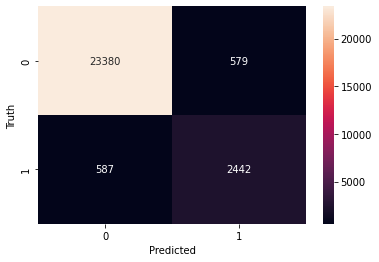

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted1)

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [43]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23959
           1       0.81      0.81      0.81      3029

    accuracy                           0.96     26988
   macro avg       0.89      0.89      0.89     26988
weighted avg       0.96      0.96      0.96     26988



In [44]:
predicted_follow_ups(y_test, y_predicted1, data1)

,doc_id,sent_index,sentence,labels
31184,27200,120,"['#', '.', 'Communication', ':', 'Patient', 'S...",[]
45922,34195,113,"['Followup', 'Instructions', ':']","['I-Appointment-related followup', 'I-Case-spe..."
28741,26493,236,"['2', '.', 'Infectious', 'disease', 'followup'...",['I-Appointment-related followup']
46283,34338,97,"['Craig', 'Gabrielle', 'Hamilton', 'Phone', ':']","['I-Appointment-related followup', 'I-Case-spe..."
54126,37447,91,"['You', 'will', 'have', 'have', 'hoarse', 'voi...",['I-Case-specific instructions for patient']
...,...,...,...,...
57667,39211,199,"['-', 'At', 'the', '3-week', 'visit', ',', 'th...","['I-Case-specific instructions for patient', '..."
56784,39046,160,"['You', 'were', 'also', 'started', 'back', 'on...",['I-Case-specific instructions for patient']
58898,39957,137,"['Campus', ':']",['I-Appointment-related followup']
54477,37687,115,"['?', '?', '?', '?', '?', '?', 'After', '1', '...",[]


In [ ]:
# Citations

# Code Basics. (2021, August 28). Text Classification Using BERT & Tensorflow | Deep Learning Tutorial 
#      47 (Tensorflow, Keras & Python). Retrieved from YouTube: https://www.youtube.com/watch?v=hOCDJyZ6quA&t=1131s
# Code Basics. (2021, July 22). What is BERT? | Deep Learning Tutorial 
#      46 (Tensorflow, Keras & Python). Retrieved from YoutTube: https://www.youtube.com/watch?v=7kLi8u2dJz0
